In [2]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
BATCH_SIZE = 100

In [4]:
def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [5]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
ds_train

<DatasetV1Adapter shapes: ((None, 32, 32, None), (None,)), types: (tf.float32, tf.int8)>

In [7]:
ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE) 

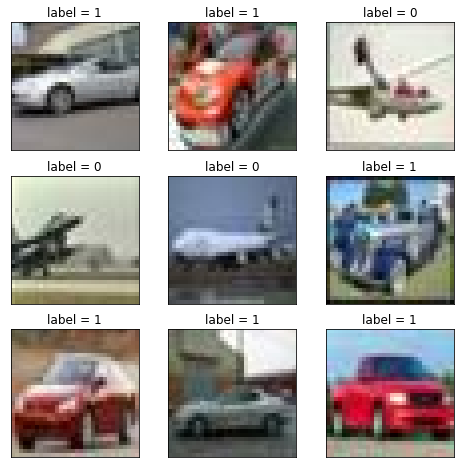

In [8]:
%matplotlib inline
#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [9]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


In [10]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [11]:
import datetime
import os

In [12]:
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
from pathlib import Path
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./models/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 0.4543 - accuracy: 0.7851 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 13s 134ms/step - loss: 0.3203 - accuracy: 0.8629 - val_loss: 0.2628 - val_accuracy: 0.8880
Epoch 3/10
100/100 [==============================] - 14s 138ms/step - loss: 0.2745 - accuracy: 0.8818 - val_loss: 0.2431 - val_accuracy: 0.8990
Epoch 4/10
100/100 [==============================] - 14s 138ms/step - loss: 0.2282 - accuracy: 0.9058 - val_loss: 0.2022 - val_accuracy: 0.9145
Epoch 5/10
100/100 [==============================] - 14s 138ms/step - loss: 0.1895 - accuracy: 0.9218 - val_loss: 0.1866 - val_accuracy: 0.9250
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 0.1676 - accuracy: 0.9325 - val_loss: 0.1704 - val_accuracy: 0.9295
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss: 0.1462 - accuracy: 0.9414 - val_loss: 0.1580 

In [13]:
%load_ext tensorboard


from tensorboard import notebook
notebook.list() 




Known TensorBoard instances:
  - port 6007: logdir ./models/autograph (started 14:41:53 ago; pid 16839)


In [14]:
#在tensorboard中查看模型
notebook.start("--logdir ./models/autograph")

Reusing TensorBoard on port 6007 (pid 16839), started 14:41:53 ago. (Use '!kill 16839' to kill it.)

In [15]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory



,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.454349,0.7851,0.336852,0.8490
2,0.320704,0.8629,0.262783,0.8880
3,0.274429,0.8818,0.243146,0.8990
4,0.228616,0.9058,0.202195,0.9145
5,0.190088,0.9218,0.186563,0.9250
6,0.168254,0.9325,0.170445,0.9295
7,0.146334,0.9414,0.157960,0.9340
8,0.121889,0.9546,0.173950,0.9320
9,0.111977,0.9575,0.157595,0.9370


In [16]:
pdf = pd.DataFrame(history.history)
pdf.head()

,loss,accuracy,val_loss,val_accuracy
0,0.454349,0.7851,0.336852,0.8490
1,0.320704,0.8629,0.262783,0.8880
2,0.274429,0.8818,0.243146,0.8990
3,0.228616,0.9058,0.202195,0.9145
4,0.190088,0.9218,0.186563,0.9250


In [17]:
pdf.index = range(1, len(pdf)+1)
pdf.index.name = 'epoch'
pdf.head()

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.454349,0.7851,0.336852,0.8490
2,0.320704,0.8629,0.262783,0.8880
3,0.274429,0.8818,0.243146,0.8990
4,0.228616,0.9058,0.202195,0.9145
5,0.190088,0.9218,0.186563,0.9250


In [18]:
len(pdf)

10

In [19]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

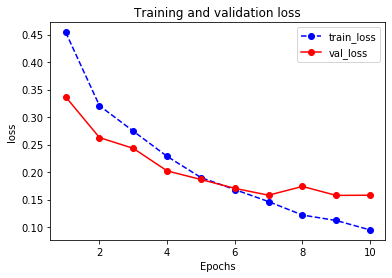

In [20]:
plot_metric(history,"loss")

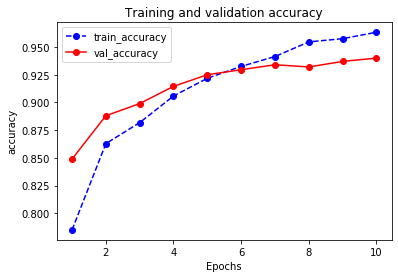

In [21]:
plot_metric(history,"accuracy")

In [22]:
history.history

{'loss': [0.45434870332479477,
  0.3207035754621029,
  0.27442881658673285,
  0.2286160195618868,
  0.19008759438991546,
  0.16825441770255567,
  0.14633393459022045,
  0.12188853114843369,
  0.11197662670165301,
  0.0948406047746539],
 'accuracy': [0.7851,
  0.8629,
  0.8818,
  0.9058,
  0.9218,
  0.9325,
  0.9414,
  0.9546,
  0.9575,
  0.9633],
 'val_loss': [0.33685198947787287,
  0.2627829939126968,
  0.24314633011817932,
  0.20219456665217878,
  0.18656255826354026,
  0.17044521793723105,
  0.15795960724353791,
  0.17394999526441096,
  0.1575945805758238,
  0.15797224156558515],
 'val_accuracy': [0.849,
  0.888,
  0.899,
  0.9145,
  0.925,
  0.9295,
  0.934,
  0.932,
  0.937,
  0.94]}

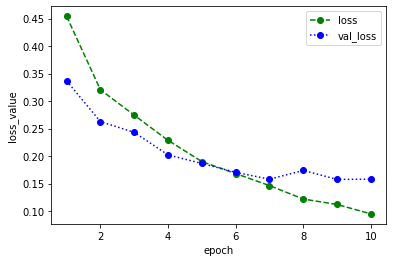

In [38]:
epochs = range(1, len(pdf) + 1)
plt.plot(epochs, history.history['loss'], 'bo--', color='green')
plt.plot(epochs, history.history['val_loss'], 'bo:', color='blue')
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.show()

In [24]:
history.history.keys

<function dict.keys>

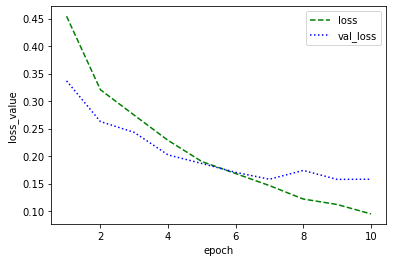

In [25]:
epochs = range(1, len(pdf) + 1)
plt.plot(epochs, history.history['loss'], ls='--', color='green')
plt.plot(epochs, history.history['val_loss'], ls=':', color='blue')
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.show()